In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import concatenate,add,dot
from keras.layers import LSTM, GRU
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from functools import reduce
import tarfile
import numpy as np
import re

train_epochs = 100
batch_size = 32
lstm_size = 64


In [2]:
def tokenize(sent):
    print(sent)
    return [ x.strip() for x in sent.split(' ')]

In [3]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

In [6]:
import pandas as pd
datframe=pd.read_csv("SQuAD.csv")

In [7]:
datframe

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"['When did Beyonce start becoming popular?', '...","['in the late 1990s', 'singing and dancing', '..."
1,1,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,"[""What was Frédéric's nationalities?"", 'In wha...","['Polish and French', 'Romantic era', 'solo pi..."
2,2,The exact nature of relations between Tibet an...,['Who were Wang Jiawei and Nyima Gyaincain?'],['Mainland Chinese scholars']
3,3,The iPod is a line of portable media players a...,"['Which company produces the iPod?', 'When was...","['Apple', 'October 23, 2001', 'three', 'portab..."
4,4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"['When did Beyonce start becoming popular?', '...","['in the late 1990s', 'singing and dancing', '..."
5,5,Frédéric François Chopin (/ˈʃoʊpæn/; French pr...,"[""What was Frédéric's nationalities?"", 'In wha...","['Polish and French', 'Romantic era', 'solo pi..."
6,6,The exact nature of relations between Tibet an...,['Who were Wang Jiawei and Nyima Gyaincain?'],['Mainland Chinese scholars']
7,7,The iPod is a line of portable media players a...,"['Which company produces the iPod?', 'When was...","['Apple', 'October 23, 2001', 'three', 'portab..."
8,8,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,"['When did Beyonce start becoming popular?', '...","['in the late 1990s', 'singing and dancing', '..."
9,9,The 2008 Sichuan earthquake or the Great Sichu...,['In what year did the earthquake in Sichuan o...,"['2008', 'the Great Sichuan earthquake', '69,1..."


In [8]:

cols=['ground_truth','questions','answers']
df=pd.DataFrame(columns=cols)
new_train_stories=[]
new_test_stories=[]
for i,j in datframe.iterrows():
  ground_truth=j[1].replace("[","").replace("]","").split(" ")
  questions=j[2].replace("[","").replace("]","").split(',')
  answers=j[3].replace("[","").replace("]","").split(',')
  for i,j in zip(questions,answers):
   
    new_train_stories.append((ground_truth,i.replace("'","").split(" "),j.replace("'","")))
    new_test_stories.append((ground_truth,i.replace("'","").split(" "),j.replace("'","")))

In [ ]:
new_train_stories

[(['Beyoncé',
   'Giselle',
   'Knowles-Carter',
   '(/biːˈjɒnseɪ/',
   'bee-YON-say)',
   '(born',
   'September',
   '4,',
   '1981)',
   'is',
   'an',
   'American',
   'singer,',
   'songwriter,',
   'record',
   'producer',
   'and',
   'actress.',
   'Born',
   'and',
   'raised',
   'in',
   'Houston,',
   'Texas,',
   'she',
   'performed',
   'in',
   'various',
   'singing',
   'and',
   'dancing',
   'competitions',
   'as',
   'a',
   'child,',
   'and',
   'rose',
   'to',
   'fame',
   'in',
   'the',
   'late',
   '1990s',
   'as',
   'lead',
   'singer',
   'of',
   'R&B',
   'girl-group',
   "Destiny's",
   'Child.',
   'Managed',
   'by',
   'her',
   'father,',
   'Mathew',
   'Knowles,',
   'the',
   'group',
   'became',
   'one',
   'of',
   'the',
   "world's",
   'best-selling',
   'girl',
   'groups',
   'of',
   'all',
   'time.',
   'Their',
   'hiatus',
   'saw',
   'the',
   'release',
   'of',
   "Beyoncé's",
   'debut',
   'album,',
   'Dangerously',
   

In [9]:
train_stories=new_train_stories
test_stories=new_test_stories
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)


vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_queries + test_queries)))

print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)

print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)


-
Vocab size: 669 unique words
Story max length: 181 words
Query max length: 14 words
Number of training stories: 157
Number of test stories: 157
-
Here's what a "story" tuple looks like (input, query, answer):
(['Beyoncé', 'Giselle', 'Knowles-Carter', '(/biːˈjɒnseɪ/', 'bee-YON-say)', '(born', 'September', '4,', '1981)', 'is', 'an', 'American', 'singer,', 'songwriter,', 'record', 'producer', 'and', 'actress.', 'Born', 'and', 'raised', 'in', 'Houston,', 'Texas,', 'she', 'performed', 'in', 'various', 'singing', 'and', 'dancing', 'competitions', 'as', 'a', 'child,', 'and', 'rose', 'to', 'fame', 'in', 'the', 'late', '1990s', 'as', 'lead', 'singer', 'of', 'R&B', 'girl-group', "Destiny's", 'Child.', 'Managed', 'by', 'her', 'father,', 'Mathew', 'Knowles,', 'the', 'group', 'became', 'one', 'of', 'the', "world's", 'best-selling', 'girl', 'groups', 'of', 'all', 'time.', 'Their', 'hiatus', 'saw', 'the', 'release', 'of', "Beyoncé's", 'debut', 'album,', 'Dangerously', 'in', 'Love', '(2003),', 'whic

In [ ]:
vocab

['',
 '  2008',
 '  Nintendo',
 ' $245',
 ' 02:28:01 PM China Standard Time',
 ' 17 October 1849',
 ' 1810',
 ' 1849',
 ' 20',
 ' 2001',
 ' 2003',
 ' 2005',
 ' 2005 ',
 ' 2006',
 ' 3',
 ' 69',
 ' 8.0 Ms and 7.9 Mw',
 ' Apple',
 ' Dangerously in Love',
 ' Daniel Craig',
 ' December 2006',
 ' Destinys Child',
 ' Duchy of Warsaw',
 ' Fryderyk Franciszek Chopin',
 ' GameCube and Wii',
 ' Houston',
 ' James Bond',
 ' Mathew Knowles',
 ' May 12',
 ' Metro-Goldwyn-Mayer and Columbia Pictures',
 ' Nintendo',
 ' November 2006',
 ' November 2006 ',
 ' October 23',
 ' Romantic',
 ' Romantic era',
 ' Sam Mendes',
 ' Shuffle',
 ' Skyfall',
 ' Spectre',
 ' Texas',
 ' Warsaw',
 ' action adventure',
 ' five',
 ' four',
 ' late 1990s',
 ' lead singer',
 ' portable media players',
 ' singing and dancing',
 ' solo piano',
 ' the Great Sichuan earthquake',
 ' three',
 ' touchscreen',
 ' twenty-four',
 '"Baby',
 '"Crazy',
 '"The',
 '"What',
 '"When',
 '"Who',
 '"poetic',
 '$245',
 '(/biːˈjɒnseɪ/',
 '(/ˈʃoʊ

In [ ]:
word_idx

{'': 1,
 '  2008': 2,
 '  Nintendo': 3,
 ' $245': 4,
 ' 02:28:01 PM China Standard Time': 5,
 ' 17 October 1849': 6,
 ' 1810': 7,
 ' 1849': 8,
 ' 20': 9,
 ' 2001': 10,
 ' 2003': 11,
 ' 2005': 12,
 ' 2005 ': 13,
 ' 2006': 14,
 ' 3': 15,
 ' 69': 16,
 ' 8.0 Ms and 7.9 Mw': 17,
 ' Apple': 18,
 ' Dangerously in Love': 19,
 ' Daniel Craig': 20,
 ' December 2006': 21,
 ' Destinys Child': 22,
 ' Duchy of Warsaw': 23,
 ' Fryderyk Franciszek Chopin': 24,
 ' GameCube and Wii': 25,
 ' Houston': 26,
 ' James Bond': 27,
 ' Mathew Knowles': 28,
 ' May 12': 29,
 ' Metro-Goldwyn-Mayer and Columbia Pictures': 30,
 ' Nintendo': 31,
 ' November 2006': 32,
 ' November 2006 ': 33,
 ' October 23': 34,
 ' Romantic': 35,
 ' Romantic era': 36,
 ' Sam Mendes': 37,
 ' Shuffle': 38,
 ' Skyfall': 39,
 ' Spectre': 40,
 ' Texas': 41,
 ' Warsaw': 42,
 ' action adventure': 43,
 ' five': 44,
 ' four': 45,
 ' late 1990s': 46,
 ' lead singer': 47,
 ' portable media players': 48,
 ' singing and dancing': 49,
 ' solo piano'

In [4]:
from IPython.display import Image

In [ ]:
idx_word

{1: '',
 2: '  2008',
 3: '  Nintendo',
 4: ' $245',
 5: ' 02:28:01 PM China Standard Time',
 6: ' 17 October 1849',
 7: ' 1810',
 8: ' 1849',
 9: ' 20',
 10: ' 2001',
 11: ' 2003',
 12: ' 2005',
 13: ' 2005 ',
 14: ' 2006',
 15: ' 3',
 16: ' 69',
 17: ' 8.0 Ms and 7.9 Mw',
 18: ' Apple',
 19: ' Dangerously in Love',
 20: ' Daniel Craig',
 21: ' December 2006',
 22: ' Destinys Child',
 23: ' Duchy of Warsaw',
 24: ' Fryderyk Franciszek Chopin',
 25: ' GameCube and Wii',
 26: ' Houston',
 27: ' James Bond',
 28: ' Mathew Knowles',
 29: ' May 12',
 30: ' Metro-Goldwyn-Mayer and Columbia Pictures',
 31: ' Nintendo',
 32: ' November 2006',
 33: ' November 2006 ',
 34: ' October 23',
 35: ' Romantic',
 36: ' Romantic era',
 37: ' Sam Mendes',
 38: ' Shuffle',
 39: ' Skyfall',
 40: ' Spectre',
 41: ' Texas',
 42: ' Warsaw',
 43: ' action adventure',
 44: ' five',
 45: ' four',
 46: ' late 1990s',
 47: ' lead singer',
 48: ' portable media players',
 49: ' singing and dancing',
 50: ' solo pi

In [10]:
print('-')
print('Compiling...')


input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)


input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))

input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)



print("--------------------------------------")

match = dot([input_encoded_m,question_encoded],axes=2, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)


response = add([match, input_encoded_c])  
response = Permute((2, 1))(response)  
print('Response shape', response)


answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)  
answer = Dropout(0.3)(answer)
answer = Dense(vocab_size)(answer)  

answer = Activation('softmax')(answer)


model = Model([input_sequence, question], answer)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

print("-------------Model Summary------------")
print(model.summary())


print("Trainig the model")
model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
      validation_data=([inputs_test, queries_test], answers_test))
model.save('squad_model.h5')




-
Compiling...
Input sequence: Tensor("input_1:0", shape=(None, 181), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 14), dtype=float32)
Input encoded m Tensor("sequential/dropout/cond/Identity:0", shape=(None, 181, 64), dtype=float32)
Input encoded c Tensor("sequential_1/dropout_1/cond/Identity:0", shape=(None, 181, 14), dtype=float32)
Question encoded Tensor("sequential_2/dropout_2/cond/Identity:0", shape=(None, 14, 64), dtype=float32)
--------------------------------------
Match shape Tensor("activation/truediv:0", shape=(None, 181, 14), dtype=float32)
Response shape Tensor("permute/transpose:0", shape=(None, 14, 181), dtype=float32)
Answer shape Tensor("concatenate/concat:0", shape=(None, 14, 245), dtype=float32)
-------------Model Summary------------
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp

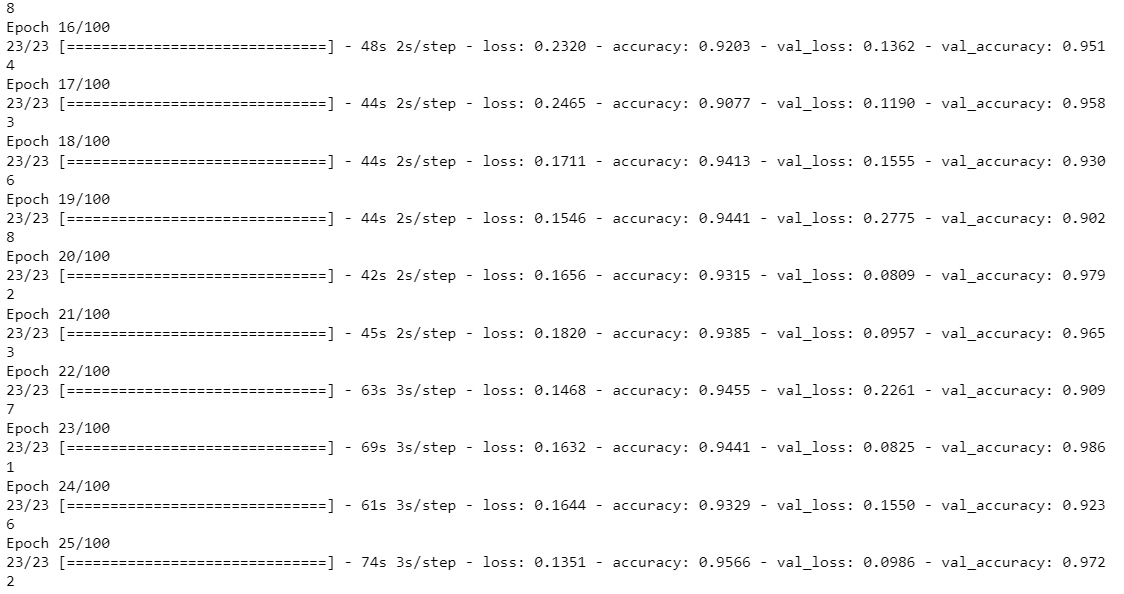

In [5]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
      validation_data=([inputs_test, queries_test], answers_test))

In [ ]:
input_encoded_m

<tf.Tensor 'sequential_1/dropout_1/cond/Merge:0' shape=(?, 181, 64) dtype=float32>

In [ ]:
input_sequence

<tf.Tensor 'input_1:0' shape=(?, 181) dtype=float32>

In [ ]:
response

<tf.Tensor 'permute_1/transpose:0' shape=(?, 14, 181) dtype=float32>

In [ ]:
match

<tf.Tensor 'activation_1/truediv:0' shape=(?, 181, 14) dtype=float32>

In [ ]:
answer

<tf.Tensor 'activation_2/Softmax:0' shape=(?, 669) dtype=float32>

In [11]:
print('-------------------------------------------------------------------------------------------')
print('Qualitative Test Result Analysis')

for i in range(0,157):
    current_inp = new_test_stories[i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
    current_prediction = idx_word[np.argmax(current_prediction)]
    print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])

print('-------------------------------------------------------------------------------------------')


-------------------------------------------------------------------------------------------
Qualitative Test Result Analysis
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy". When did Beyonce start becoming popular? | Prediction: in the late 1990s | Ground Truth: in the late 1990s
Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September

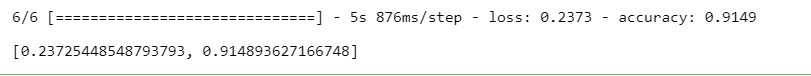

In [6]:
model.evaluate([test_stories, test_queries])

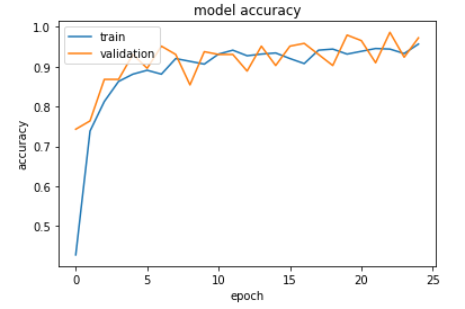

In [7]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
   plt.xlabel("epoch")
   plt.legend(["train", "validation"], loc="upper left")
    plt.show()
plot_hist(history)